1\. Write a function that converts numbers among the bin, dec, and hex representations (bin<->dec<->hex)

In [1]:
def converter(a):
    if(type(a) == int):
        return a, bin(a), hex(a)
    elif(type(a) == str):
        if a[0] == '0':
            if a[1] == 'b':
                a_decimal = int (a, 2) 
                return a_decimal, a, hex(a_decimal)
            elif a[1] == 'x':
                a_decimal = int (a, 16) 
                return a_decimal, bin(a_decimal), a
            else:
                raise Exception('Format not valid')
        else:
            raise Exception('Format not valid')
    else:
        raise Exception('Type not valid')
    

x = 29
print(converter(x))
x = bin(x)
print(converter(x))
x = hex(int(x,2))
print(converter(x))


(29, '0b11101', '0x1d')
(29, '0b11101', '0x1d')
(29, '0b11101', '0x1d')


2\. Write a function that converts a 32 bit word into a single precision floating point (i.e. interprets the various bits as sign, mantissa and exponent) and check its validity.

In [2]:
import struct
import random

def create_mask(n_of_bits):
    mask = '0b'
    for i in range(n_of_bits):
        mask += '1'
    return int(mask, 2)

def converter(x):
    m_n_of_bits = 23
    e_n_of_bits = 8
    s_n_of_bits = 1
    #mantissa
    int_mantissa = create_mask(m_n_of_bits) & x
    float_mantissa = 1.0
    negative_power_two = 1
    submask = '0b1'
    for i in range(m_n_of_bits -1):
        submask += '0'
    submask = int(submask, 2)
    for i in range(m_n_of_bits):
        negative_power_two *= 0.5
        if (submask & int_mantissa == submask):
            float_mantissa += negative_power_two
        int_mantissa = int_mantissa << 1
    #exponent
    x = x >> m_n_of_bits
    int_exponent = (create_mask(e_n_of_bits) & x) - 127
    #sign
    x = x >> e_n_of_bits
    if create_mask(s_n_of_bits) & x:
        float_mantissa *= (-1)
    return(float_mantissa*2**(int_exponent))

for i in range(10):
    number_to_convert = (random.random()-0.5)* 10000
    bin_number = struct.pack('>f', number_to_convert)
    int_bin_num = struct.unpack('>l', bin_number)[0] #Binary but in int type
    float_number = struct.unpack('>f', bin_number)[0]
    my_conversion = converter(int_bin_num)
    print(float_number, "==", my_conversion, float_number == my_conversion)


-649.46826171875 == -649.46826171875 True
-3628.918212890625 == -3628.918212890625 True
-3087.469970703125 == -3087.469970703125 True
2019.52392578125 == 2019.52392578125 True
-4957.02392578125 == -4957.02392578125 True
3091.417724609375 == 3091.417724609375 True
3993.662353515625 == 3993.662353515625 True
288.43182373046875 == 288.43182373046875 True
-774.9124755859375 == -774.9124755859375 True
-441.7502136230469 == -441.7502136230469 True


3\. Write a program to determine the underflow and overflow limits (within a factor of 2) for python on your computer. 

**Tip**: define two variables initialized to 1 and halve/double them for a sufficient amount of times to exceed the under/over-flow limits  

In [3]:
#Integers do not overflow
import math
over = 1.0
while True:
    next_value = over*2
    if math.isinf(next_value):
        print('Max value =', over)
        break
    else:
        over = next_value
under = 1.0
while True:
    next_value = under/2
    if next_value == 0:
        print('Min value =', under)
        break
    else:
        under = next_value


Max value = 8.98846567431158e+307
Min value = 5e-324


4\. Write a program to determine the machine precision

**Tip**: define a new variable by adding an increasingly smaller value (in the same way as the previous problem) and check when the addition starts to have no effect on the number

In [4]:
def precision(centre):
    #centre in 0 would return 0, because 0 + delta == 0 is true only if delta underflows
    if centre == 0:
        under = 1.0
        while True:
            next_value = under/2
            if next_value == 0:
                return under
            else:
                under = next_value
    delta = 1.0
    while True:
        if centre + delta == centre:
            return delta
        delta /= 2

print(precision(0))
print(precision(1))
print(precision(100))
print(precision(10000))
print(precision(1000000))
print(precision(100000000))

5e-324
1.1102230246251565e-16
7.105427357601002e-15
9.094947017729282e-13
5.820766091346741e-11
7.450580596923828e-09


5\. Write a function that takes in input three parameters $a$, $b$ and $c$ and prints out the two solutions to the quadratic equation $ax^2+bx+c=0$ using the standard formula:
$$
x=\frac{-b\pm\sqrt{b^2-4ac}}{2a}
$$

(a) use the program to compute the solution for $a=0.001$, $b=1000$ and $c=0.001$

(b) re-express the standard solution formula by multiplying the numerator and the denominator by $-b\mp\sqrt{b^2-4ac}$ and again find the solution for $a=0.001$, $b=1000$ and $c=0.001$. How does it compare with what has been previously obtained, and why?

(c) write a function that computes the roots of a quadratic equation accurately in all cases

In [5]:
def roots(a, b, c):
    r = (b**2-4*a*c)**0.5
    return (-b+r)/(2*a), (-b-r)/(2*a)

def roots2(a, b, c):
    r = (b**2-4*a*c)**0.5
    return -(2*a*c)/(a*(b+r)),(2*a*c)/(a*(-b+r))

print('Solutions are {:e}, {:e}\n'.format(-10**(-6), -10**(6)))
r = roots(0.001, 1000, 0.001)
print('{:e}, {:e}'.format(r[0], r[1]),'\nFirst solution is wrong')
r = roots2(0.001, 1000, 0.001)
print('{:e}, {:e}'.format(r[0], r[1]),'\nSecond solution is wrong\n')

print('The problem is related to the calculus of b-r, to obtain a stable version we need to avoid this subtraction\n')

def stable_roots(a,b,c):
    r = (b**2-4*a*c)**0.5
    return -(2*a*c)/(a*(b+r)), -(b+r)/(2*a)

r = stable_roots(0.001, 1000, 0.001)
print('With stable version:\n{:e}, {:e}'.format(r[0], r[1]))


Solutions are -1.000000e-06, -1.000000e+06

-9.999894e-07, -1.000000e+06 
First solution is wrong
-1.000000e-06, -1.000011e+06 
Second solution is wrong

The problem is related to the calculus of b-r, to obtain a stable version we need to avoid this subtraction

With stable version:
-1.000000e-06, -1.000000e+06


6\. Write a program that implements the function $f(x)=x(x−1)$

(a) Calculate the derivative of the function at the point $x = 1$ using the derivative definition:

$$
\frac{{\rm d}f}{{\rm d}x} = \lim_{\delta\to0} \frac{f(x+\delta)-f(x)}{\delta}
$$

with $\delta = 10^{−2}$. Calculate the true value of the same derivative analytically and compare it with the answer your program gives. The two will not agree perfectly. Why?

(b) Repeat the calculation for $\delta = 10^{−4}, 10^{−6}, 10^{−8}, 10^{−10}, 10^{−12}$ and $10^{−14}$. How does the accuracy scales with $\delta$?

In [6]:
def my_function(x):
    return x*(x-1)

def definition_derivative(fun, x, delta):
    return (fun(x+delta) - fun(x))/delta

print('For the given function the derivative is f\'(x)=2x-1.\nSo the value in x=1 should be f\'(1)=1\nBut for the given formula the result is df/dx(1) = 1 + \u03B4\n')

for i in range(1, 8):
    print('with \u03B4 = {:e} the value f\'(1) = {}\nThe difference from the analytic result is = {:e}\nThe difference from f\'(1) = 1 is {:e}\n'.format(10**(-2*i), definition_derivative(my_function, 1, 10**(-2*i)),definition_derivative(my_function, 1, 10**(-2*i)) - (1 + 10**(-2*i)), definition_derivative(my_function, 1, 10**(-2*i)) -1))

print('We can observe that for bigger value of \u03B4 the result is close to the analytic result 1 + \u03B4 but far away form the true result.\nAs \u03B4 decreases the result gets farther from the analytical one but closer to the true result.\nThis due to the fact that the function is well-conditioned but the algorithm is unstable.\nThe best tradeoff is \u03B4 = 10^(-8)')

For the given function the derivative is f'(x)=2x-1.
So the value in x=1 should be f'(1)=1
But for the given formula the result is df/dx(1) = 1 + δ

with δ = 1.000000e-02 the value f'(1) = 1.010000000000001
The difference from the analytic result is = 8.881784e-16
The difference from f'(1) = 1 is 1.000000e-02

with δ = 1.000000e-04 the value f'(1) = 1.0000999999998899
The difference from the analytic result is = -1.101341e-13
The difference from f'(1) = 1 is 1.000000e-04

with δ = 1.000000e-06 the value f'(1) = 1.0000009999177333
The difference from the analytic result is = -8.226664e-11
The difference from f'(1) = 1 is 9.999177e-07

with δ = 1.000000e-08 the value f'(1) = 1.0000000039225287
The difference from the analytic result is = -6.077471e-09
The difference from f'(1) = 1 is 3.922529e-09

with δ = 1.000000e-10 the value f'(1) = 1.000000082840371
The difference from the analytic result is = 8.274037e-08
The difference from f'(1) = 1 is 8.284037e-08

with δ = 1.000000e-12 the valu

7\. Consider the integral of the semicircle of radius 1:
$$
I=\int_{-1}^{1} \sqrt(1-x^2) {\rm d}x
$$
which is known to be $I=\frac{\pi}{2}=1.57079632679...$.

Alternatively we can use the Riemann definition of the integral:
$$
I=\lim_{N\to\infty} \sum_{k=1}^{N} h y_k 
$$

with $h=2/N$ the width of each of the $N$ slices the domain is divided into and where
$y_k$ is the value of the function at the $k-th$ slice.

(a) Write a program to compute the integral with $N=100$. How does the result compare to the true value?

(b) How much can $N$ be increased if the computation needs to be run in less than a second? What is the gain in running it for 1 minute? 


Since the number of operation is linear in N also the time to execute the function is roughly linear in N, with some trials I obtained:

With N = 100
1.5712827762297958 relative error 0.030958745444056295 %
Time to compute it =  3.8356933e-05 s

With N = 2400000
1.5707963269259537 relative error 8.343358261906239e-09 %
Time to compute it =  0.98158259 s

With N = 135000000
1.5707963267949145 relative error 1.1449996853268528e-12 %
Time to compute it =  58.8568861 s



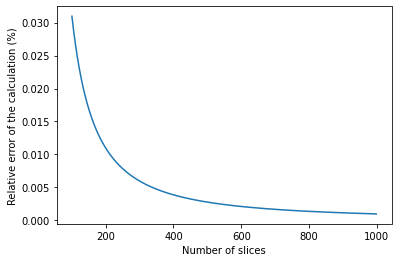

The relative error is inversely proportional to N, this relationship is not linear as you can see from the graph


In [7]:
from math import pi
import timeit
import matplotlib.pyplot as plt

def riemann_integral(fun, N, domain):
    half_slice = (domain[1]-domain[0])/(N*2)
    mid_slice_value = [domain[0]+half_slice*(1+2*x) for x in range(N)]
    out = 0
    for v in mid_slice_value:
        out += 2*half_slice*fun(v)
    return out

def semicircle(x):
    return (1-x**2)**0.5

print('Since the number of operation is linear in N also the time to execute the function is roughly linear in N, with some trials I obtained:\n')
def my_timer(n_slices, n_trial):
    print('With N =', n_slices)
    i = riemann_integral(semicircle, n_slices, (-1,1))
    print(i, 'relative error', 100*(i-(pi/2))/i, '%')
    print("Time to compute it = ", timeit.timeit('riemann_integral(semicircle, '+str(n_slices)+', (-1,1))', 'from __main__ import riemann_integral, semicircle', number=n_trial)/n_trial,'s\n')

my_timer(100, 100000)
my_timer(2400000, 10)
my_timer(135000000, 1)

x = ()
y = ()
for N in range(100,1000):
    i = riemann_integral(semicircle, N, (-1,1))
    x += (N, )
    y += (100*(i-(pi/2))/i, )

plt.plot(x,y)
plt.xlabel('Number of slices')
plt.ylabel('Relative error of the calculation (%)')
plt.show()

print('The relative error is inversely proportional to N, this relationship is not linear as you can see from the graph')